In [52]:
import glob
import json
import more_itertools
import numpy as np
import sys

expt_num = "ct8.5"
sys.path.append("./nlp_logs/{}/".format(expt_num)) # go to parent dir
expt_loc = "nlp_logs/{}/".format(expt_num)
len(glob.glob("nlp_logs/{}/*.json".format(expt_num)))

19

In [2]:
! pip install more_itertools

In [28]:
def get_irm_score(result_dict,num_domains):
    '''
    '''
    #Correcting the classifier if the labeeling is learnt is reverse manner
    for curr_cat in result_dict["data_args"]["cat_list"]:
        optimal_vacc = result_dict["ood_vacc"][curr_cat][curr_cat]
        #Flip the labels if we are getting the wrong labels (this shouldn't have happened)
        if(optimal_vacc<0.5):
            for oth_cat in result_dict["data_args"]["cat_list"]:
                result_dict["ood_vacc"][curr_cat][oth_cat]= 1-result_dict["ood_vacc"][curr_cat][oth_cat]
        
        
    
    #Iterating overall the domains
#     print("Getting spurousness score for:{}".format(result_dict["alive_feature_dims"]))
    all_perf_drop = []
    for curr_cat in result_dict["data_args"]["cat_list"][0:num_domains]:
        optimal_vacc = result_dict["ood_vacc"][curr_cat][curr_cat]
        
            
        #how the current classifier is different from the otherdomains
        for oth_cat in result_dict["data_args"]["cat_list"][0:num_domains]:
            if(curr_cat==oth_cat):
                continue
            
            #Now get the performance of this domain on other optimal classifier
            other_vacc = result_dict["ood_vacc"][oth_cat][curr_cat]
            perf_drop = other_vacc - optimal_vacc
            all_perf_drop.append(perf_drop)
            
#             if(perf_drop>0):
#                 print("Perf Better than optimal perf:\tcurr:{}\tother:{}\tdrop:{}".format(curr_cat,oth_cat,perf_drop))
    
    return np.mean(np.abs(all_perf_drop))
            
        

def read_all_result_file(num_domains):
    all_result_dict={}
    for res_file in glob.glob("{}/*.json".format(expt_loc)):
        with open(res_file,"r") as rhandle:
            res_dict = json.load(rhandle)
            #Adding the new spuriousness scrore
            irm_score = get_irm_score(res_dict,num_domains)
            res_dict["ood_meta_dict"]["irm_score"]=irm_score
            
            all_result_dict[tuple(res_dict["alive_feature_dims"])] = res_dict
    
    return all_result_dict


In [19]:
import numpy as np
np.random.seed(22)
from scipy.special import softmax
    
def spurious_by_em(all_result_dict,num_epochs):
    init_temp=1000.0
    num_feat = len(all_result_dict[tuple()]["data_args"]["topic_list"])
#     logit_spurious = np.random.uniform(low=0.0,high=1.0,size=num_feat)
    logit_spurious = np.ones((num_feat,))
    
    #Now refining the estimate
    overall_spurious_sum = 1.0
    for epoch in range(num_epochs):
        new_temp = 1.0 #+ init_temp/(1.5**epoch)
        prob_spurious = logit_spurious/overall_spurious_sum #/np.sum(logit_spurious)#softmax(logit_spurious/new_temp)
        sprob_list = [float("{:0.2f}".format(prob_spurious[fidx])) for fidx in range(num_feat)]
        
        #Get the spurious subset sample
        spurious_sub = []
        for fidx in range(num_feat):
            if np.random.choice([0,1],p=[1-prob_spurious[fidx],prob_spurious[fidx]])==1:
                spurious_sub.append(fidx)
        #Choosing the spurious subset by sampling from overall distribution
#         spurious_sub = np.random.choice(range(num_feat),size=np.random.randint(num_feat),replace=False,p=prob_spurious).tolist()
#         spurious_sub.sort()
        #Get the other subset
        other_sub = set(range(num_feat)).difference(spurious_sub)
        
        
        #Now getting the scores
        spurious_score = all_result_dict[tuple(spurious_sub)]["ood_meta_dict"]["irm_score"]
#         other_score    = all_result_dict[tuple(other_sub)]["ood_meta_dict"]["irm_score"]
        
        
        #Getting the new the probability
#         spurious_prob = spurious_score / (spurious_score+other_score)
#         other_prob    = 1-spurious_prob 
        
#         #Updating the probability 
#         for fidx in range(num_feat):
#             if(fidx in spurious_sub):
#                 logit_spurious[fidx]+=spurious_score
#             else:
#                 pass
#                 logit_spurious[fidx]+=other_score
        #Converting this back to logits
#         logit_spurious = np.log(prob_spurious+1e-10)
        
        #Getting the individual contribution to the current score
        blame_list=[]
        for fidx in spurious_sub:
            #Get the contribution sfter removing this feature
            removed_sub = list(set(spurious_sub).difference([fidx]))
            removed_sub.sort()
            
            #Getting the difference
            blame = spurious_score - all_result_dict[tuple(removed_sub)]["ood_meta_dict"]["irm_score"]
            blame = blame if blame>0 else 0.0
            
            blame_list.append(blame)
        #Getting the contribution ratio
        blame_list = np.array(blame_list)/(np.sum(blame_list)+1e-10)
        
        #Now distributing the score and updating the probability of these spurious index
        for tidx,fidx in enumerate(spurious_sub):
            logit_spurious[fidx]+=spurious_score*blame_list[tidx] 
        #Adding the spuroiusness score to global score
        overall_spurious_sum += spurious_score
            
        
        
        
        print("sprobs:{}\tssub:{}".format(
                                                                            
                                                                            
                                                                            sprob_list,
                                                                            spurious_sub,
        ))

# Spurious EM

In [20]:
all_result_dict = read_all_result_file()
spurious_by_em(all_result_dict,100)

sprobs:[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]	ssub:[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
sprobs:[0.96, 0.99, 0.96, 0.97, 0.96, 0.96, 0.96, 0.96, 0.96, 0.97]	ssub:[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
sprobs:[0.93, 0.98, 0.93, 0.94, 0.93, 0.93, 0.93, 0.93, 0.93, 0.94]	ssub:[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
sprobs:[0.89, 0.97, 0.89, 0.92, 0.89, 0.89, 0.89, 0.89, 0.89, 0.91]	ssub:[1, 3, 4, 5, 6, 7, 8, 9]
sprobs:[0.86, 0.92, 0.86, 0.88, 0.86, 0.87, 0.86, 0.86, 0.88, 0.87]	ssub:[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
sprobs:[0.83, 0.91, 0.83, 0.85, 0.83, 0.85, 0.83, 0.83, 0.85, 0.84]	ssub:[0, 1, 3, 4, 5, 6, 8, 9]
sprobs:[0.79, 0.88, 0.79, 0.82, 0.8, 0.81, 0.8, 0.79, 0.83, 0.81]	ssub:[0, 1, 3, 4, 5, 8, 9]
sprobs:[0.76, 0.87, 0.76, 0.79, 0.77, 0.78, 0.77, 0.76, 0.8, 0.79]	ssub:[2, 3, 4, 5, 6, 8, 9]
sprobs:[0.73, 0.83, 0.73, 0.76, 0.75, 0.76, 0.75, 0.73, 0.78, 0.77]	ssub:[0, 1, 3, 5, 8, 9]
sprobs:[0.72, 0.81, 0.71, 0.74, 0.73, 0.73, 0.72, 0.71, 0.75, 0.74]	ssub:[0, 2, 3, 4, 6, 9]
sprobs:[0.72, 0.79, 0.69, 0

In [8]:
#Checking the idea that sum of spurious score of a feature will give the probability that its spurious
def get_sprob_by_sum():
    all_result_dict = read_all_result_file()
    num_feat = len(all_result_dict[tuple()]["data_args"]["topic_list"])
    feat_irm_score = np.zeros((num_feat,))

    total_irm_sum = 0.0

    for alive_sub in all_result_dict.keys():
        total_irm_sum += all_result_dict[alive_sub]["ood_meta_dict"]["irm_score"]
        sub_irm_score = all_result_dict[alive_sub]["ood_meta_dict"]["irm_score"]

        #Now checking if any of the feature are there in this subset
        for fidx in range(num_feat):
            if fidx in alive_sub:
                feat_irm_score[fidx]+=all_result_dict[alive_sub]["ood_meta_dict"]["irm_score"]
        
        #Now distributing the blame of this psuriousness on individual feature
#         blame_list=[]
#         for fidx in alive_sub:
#             #Get the contribution sfter removing this feature
#             removed_sub = list(set(alive_sub).difference([fidx]))
#             removed_sub.sort()
            
#             #Getting the difference
#             blame = sub_irm_score - all_result_dict[tuple(removed_sub)]["ood_meta_dict"]["irm_score"]
#             blame = blame if blame>0 else 0.0
            
#             blame_list.append(blame)
#         #Getting the contribution ratio
#         blame_list = np.array(blame_list)/(np.sum(blame_list)+1e-10)
        
#         #Now distributing the score
#         for tidx,fidx in enumerate(alive_sub):
#             feat_irm_score[fidx]+=sub_irm_score*blame_list[tidx]
            

    #Now getting the overall spuriousness probability
    overall_sprob1 = feat_irm_score/total_irm_sum
    overall_sprob2 = feat_irm_score/np.sum(feat_irm_score)
    
    for fidx in range(num_feat):
        print("fidx: {}\tsprob1: {:0.2f}\tsprob2: {:0.2f}".format(fidx,overall_sprob1[fidx],overall_sprob2[fidx]))

get_sprob_by_sum()

fidx: 0	sprob1: 0.49	sprob2: 0.10
fidx: 1	sprob1: 0.51	sprob2: 0.10
fidx: 2	sprob1: 0.47	sprob2: 0.09
fidx: 3	sprob1: 0.51	sprob2: 0.10
fidx: 4	sprob1: 0.50	sprob2: 0.10
fidx: 5	sprob1: 0.58	sprob2: 0.11
fidx: 6	sprob1: 0.55	sprob2: 0.11
fidx: 7	sprob1: 0.49	sprob2: 0.10
fidx: 8	sprob1: 0.54	sprob2: 0.10
fidx: 9	sprob1: 0.51	sprob2: 0.10


In [9]:
#Checking the idea that sum of spurious score of a feature will give the probability that its spurious
def get_sprob_by_sum():
    all_result_dict = read_all_result_file()
    num_feat = len(all_result_dict[tuple()]["data_args"]["topic_list"])
    feat_irm_score = np.zeros((num_feat,))

    total_irm_sum = 0.0

    for alive_sub in all_result_dict.keys():
        total_irm_sum += all_result_dict[alive_sub]["ood_meta_dict"]["irm_score"]
        sub_irm_score = all_result_dict[alive_sub]["ood_meta_dict"]["irm_score"]

        #Now checking if any of the feature are there in this subset
#         for fidx in range(num_feat):
#             if fidx in alive_sub:
#                 feat_irm_score[fidx]+=all_result_dict[alive_sub]["ood_meta_dict"]["irm_score"]
        
        #Now distributing the blame of this psuriousness on individual feature
        blame_list=[]
        for fidx in alive_sub:
            #Get the contribution sfter removing this feature
            removed_sub = list(set(alive_sub).difference([fidx]))
            removed_sub.sort()
            
            #Getting the difference
            blame = sub_irm_score - all_result_dict[tuple(removed_sub)]["ood_meta_dict"]["irm_score"]
            blame = blame if blame>0 else 0.0
            
            blame_list.append(blame)
        #Getting the contribution ratio
        blame_list = np.array(blame_list)/(np.sum(blame_list)+1e-10)
        
        #Now distributing the score
        for tidx,fidx in enumerate(alive_sub):
            feat_irm_score[fidx]+=sub_irm_score*blame_list[tidx]
            

    #Now getting the overall spuriousness probability
    overall_sprob1 = feat_irm_score/total_irm_sum
    overall_sprob2 = feat_irm_score/np.sum(feat_irm_score)
    
    for fidx in range(num_feat):
        print("fidx: {}\tsprob1: {:0.2f}\tsprob2: {:0.2f}".format(fidx,overall_sprob1[fidx],overall_sprob2[fidx]))

get_sprob_by_sum()

fidx: 0	sprob1: 0.08	sprob2: 0.08
fidx: 1	sprob1: 0.08	sprob2: 0.08
fidx: 2	sprob1: 0.05	sprob2: 0.05
fidx: 3	sprob1: 0.06	sprob2: 0.06
fidx: 4	sprob1: 0.05	sprob2: 0.06
fidx: 5	sprob1: 0.24	sprob2: 0.25
fidx: 6	sprob1: 0.14	sprob2: 0.14
fidx: 7	sprob1: 0.06	sprob2: 0.07
fidx: 8	sprob1: 0.12	sprob2: 0.13
fidx: 9	sprob1: 0.08	sprob2: 0.08


# IRM Score

In [42]:
all_result_dict = read_all_result_file()
all_result_list = [(key,all_result_dict[key]["ood_meta_dict"]["irm_score"]) for key in all_result_dict.keys()]
all_result_list.sort(key=lambda x:x[-1])
all_result_list[-1000:]

TypeError: read_all_result_file() missing 1 required positional argument: 'num_domains'

In [56]:
all_result_dict = read_all_result_file(num_domains=9)
all_result_list = [(key,all_result_dict[key]["ood_meta_dict"]["irm_score"]) for key in all_result_dict.keys() if len(key)==1]
all_result_list.sort(key=lambda x:x[-1])
all_result_list[-1000:]

[((1,), 0.01497695701462882),
 ((2,), 0.01872120052576065),
 ((4,), 0.01925609154360635),
 ((16,), 0.021436797188861028),
 ((7,), 0.02427583560347557),
 ((17,), 0.026991442910262516),
 ((3,), 0.03143515544278281),
 ((13,), 0.032052326415266306),
 ((15,), 0.03287525687898908),
 ((12,), 0.03966425359249115),
 ((5,), 0.04365536304456847),
 ((14,), 0.048016795090266635),
 ((6,), 0.04888084956577846),
 ((8,), 0.04958031007221767),
 ((11,), 0.05233706108161381),
 ((10,), 0.06319946689265114),
 ((0,), 0.06538018531032971),
 ((9,), 0.0701119037611144)]

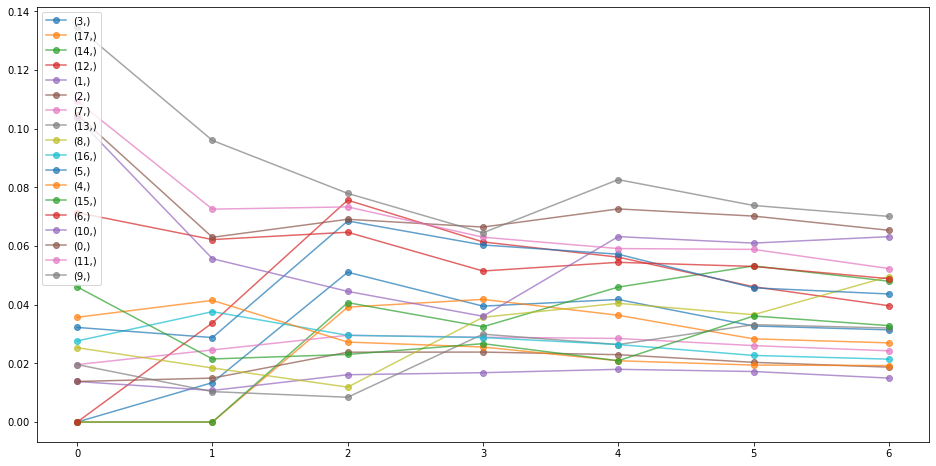

In [57]:
from collections import defaultdict
irm_timeline_dict=defaultdict(list)
num_domains = 8
for num_domain in range(2,num_domains+1):
    all_result_dict = read_all_result_file(num_domain)
    all_result_list = [(key,all_result_dict[key]["ood_meta_dict"]["irm_score"]) for key in all_result_dict.keys() if len(key)==1]
    all_result_list.sort(key=lambda x:x[-1])
    
    #Adding the results to the timeline
    for fidx,score in all_result_list:
        irm_timeline_dict[fidx].append(score)

#Plotting the IRM variation
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]
for fidx,timeline in irm_timeline_dict.items():
    plt.plot(timeline,"o-",alpha=0.7,label="{}".format(fidx))
plt.legend()

In [58]:
#First of all lets take out the indomain accuracy for the whole feature to get upperbound
all_result_dict = read_all_result_file(num_domains=9)
all_feat_result = all_result_dict[tuple(range(18))]
ood_vacc = all_feat_result["ood_vacc"]
indo_vacc = {}
for cat in ood_vacc.keys():
    indo_vacc[cat]=ood_vacc[cat][cat]
indo_vacc

{'arts': 0.7211981415748596,
 'books': 0.7165898680686951,
 'phones': 0.6612903475761414,
 'clothes': 0.6635944843292236,
 'groceries': 0.7119815945625305,
 'movies': 0.7373272180557251,
 'pets': 0.7142857313156128,
 'tools': 0.7903226017951965}

# Overall Drop

In [12]:
all_result_dict = read_all_result_file()
all_result_list = [(key,all_result_dict[key]["ood_meta_dict"]["overall_ood_drop"]) for key in all_result_dict.keys()]
all_result_list.sort(key=lambda x:x[-1])
all_result_list

[((4, 5, 6, 8, 9), -4.774193644523621),
 ((5, 6, 8), -4.741935521364212),
 ((3, 4, 5, 6, 8, 9), -4.688939929008484),
 ((4, 5, 8), -4.364055097103119),
 ((1, 3, 4, 5, 6, 9), -4.350229889154434),
 ((3, 4, 5, 6, 9), -4.343318223953247),
 ((3, 4, 5, 6, 8), -4.30184343457222),
 ((1, 3, 5, 6, 8, 9), -4.294930696487427),
 ((1, 5, 6, 8), -4.290322631597519),
 ((5, 6, 8, 9), -4.2281107902526855),
 ((1, 4, 5, 6, 8, 9), -4.228110730648041),
 ((1, 5, 6, 8, 9), -4.1566818952560425),
 ((4, 5, 6, 9), -4.147465169429779),
 ((3, 5, 6, 8), -4.138248980045319),
 ((1, 3, 5, 6, 7, 8), -4.108294874429703),
 ((0, 1, 3, 5, 6, 8, 9), -4.108294665813446),
 ((3, 5, 6, 8, 9), -4.096774369478226),
 ((5, 6, 7, 8, 9), -4.073732703924179),
 ((1, 4, 5, 6), -4.071428120136261),
 ((4, 5, 6, 7, 8, 9), -4.069123834371567),
 ((1, 3, 5, 6, 9), -4.064515829086304),
 ((3, 5, 6, 9), -4.0599077343940735),
 ((1, 4, 5, 6, 8), -4.055299520492554),
 ((1, 4, 5, 6, 7, 8, 9), -4.052995890378952),
 ((1, 4, 5, 6, 9), -4.025345206260681)

In [13]:
all_result_dict = read_all_result_file()
all_result_list = [(key,all_result_dict[key]["ood_meta_dict"]["mean_ood_drop"]) for key in all_result_dict.keys() if len(key)==1]
all_result_list.sort(key=lambda x:x[-1])
all_result_list[0:1000]

[((5,), -0.08682998387437117),
 ((2,), -0.06015470198222569),
 ((8,), -0.05786954324979048),
 ((7,), -0.05374084150089937),
 ((0,), -0.0513495568718229),
 ((6,), -0.04665898717939854),
 ((1,), -0.04429084283334238),
 ((9,), -0.03092016520038728),
 ((3,), -0.020065297683080036),
 ((4,), -0.016705062240362167)]

In [14]:
all_result_dict = read_all_result_file()
all_result_list = [(key,all_result_dict[key]["ood_meta_dict"]["overall_ood_drop"]) for key in all_result_dict.keys() if len(key)==1]
all_result_list.sort(key=lambda x:x[-1])
all_result_list[0:1000]

[((5,), -3.2995393872261047),
 ((7,), -1.8271886110305786),
 ((2,), -1.6843316555023193),
 ((8,), -1.5046081244945526),
 ((6,), -1.4930875897407532),
 ((0,), -1.4377875924110413),
 ((1,), -1.1958527565002441),
 ((9,), -0.9585251212120056),
 ((3,), -0.4815671443939209),
 ((4,), -0.400921493768692)]

# Overall Average

In [15]:
all_result_dict = read_all_result_file()
all_result_list = [(key,all_result_dict[key]["ood_meta_dict"]["mean_all_vacc"]) for key in all_result_dict.keys() if len(key)==1]
all_result_list.sort(key=lambda x:x[-1])
all_result_list[-1000:]

[((4,), 0.49078340409323573),
 ((6,), 0.4977678507566452),
 ((9,), 0.5011160732246935),
 ((3,), 0.5046442919410765),
 ((8,), 0.5073444633744657),
 ((5,), 0.5385944796726108),
 ((1,), 0.5561635792255402),
 ((7,), 0.5748847997747362),
 ((0,), 0.6036866381764412),
 ((2,), 0.6385728735476732)]

In [16]:
all_result_dict = read_all_result_file()
all_result_list = [(key,all_result_dict[key]["ood_meta_dict"]["mean_all_vacc"]) for key in all_result_dict.keys()]
all_result_list.sort(key=lambda x:x[-1])
all_result_list[-1000:]

[((3, 4, 6, 8), 0.5190452192910016),
 ((3, 6, 9), 0.5209533381275833),
 ((3, 8, 9), 0.5213493662886322),
 ((4, 6, 8, 9), 0.5216013831086457),
 ((8, 9), 0.5228254604153335),
 ((3, 4, 8), 0.5235095079988241),
 ((4, 5, 9), 0.5249495999887586),
 ((4, 5, 8, 9), 0.5270017292350531),
 ((3, 6, 8, 9), 0.5278657823801041),
 ((3, 4, 5, 6, 8, 9), 0.5289818528108299),
 ((3, 4, 5, 9), 0.5306379622779787),
 ((4, 5, 6, 8, 9), 0.5316100269556046),
 ((3, 4, 8, 9), 0.5317540331743658),
 ((5, 6, 9), 0.5339861777611077),
 ((4, 5, 8), 0.5349582405760884),
 ((3, 5, 6), 0.5362543254159391),
 ((3, 6, 7, 8, 9), 0.5365063333883882),
 ((3, 4, 5, 7, 8), 0.5371183776296675),
 ((5, 8, 9), 0.5377664179541171),
 ((5, 6, 8, 9), 0.5381984487175941),
 ((5,), 0.5385944796726108),
 ((4, 5, 6), 0.5387744856998324),
 ((3, 4, 5, 8, 9), 0.5390985039994121),
 ((5, 6, 8), 0.539746546652168),
 ((5, 6), 0.5405025947839022),
 ((3, 5, 6, 9), 0.5405385931953788),
 ((4, 5), 0.5407546162605286),
 ((3, 4, 5, 6, 8), 0.5414746585302055),


# OOD Average

In [186]:
all_result_dict = read_all_result_file()
num_cat = len(all_result_dict[()]["data_args"]["cat_list"])
all_result_list = [
                    (
                        key,
                        (  (all_result_dict[key]["ood_meta_dict"]["mean_all_vacc"]*(num_cat**2)) - (all_result_dict[key]["ood_meta_dict"]["mean_indo_vacc"]*(num_cat))    )/(num_cat*(num_cat-1))
                    ) 
                               for key in all_result_dict.keys() if len(key)==1
                  ]
all_result_list.sort(key=lambda x:x[-1])
all_result_list[-1000:]

[((4,), 0.4922234926904951),
 ((6,), 0.49790158442088533),
 ((9,), 0.503785388810294),
 ((3,), 0.5051431655883789),
 ((8,), 0.5097926003592355),
 ((5,), 0.546329847403935),
 ((1,), 0.5561635494232178),
 ((7,), 0.5895737409591675),
 ((0,), 0.6036866307258606),
 ((2,), 0.639976978302002)]

In [188]:
all_result_dict = read_all_result_file()
num_cat = len(all_result_dict[()]["data_args"]["cat_list"])
all_result_list = [
                    (
                        key,
                        (  (all_result_dict[key]["ood_meta_dict"]["mean_all_vacc"]*(num_cat**2)) - (all_result_dict[key]["ood_meta_dict"]["mean_indo_vacc"]*(num_cat))    )/(num_cat*(num_cat-1))
                    ) 
                               for key in all_result_dict.keys()
                  ]
all_result_list.sort(key=lambda x:x[-1])
all_result_list[-1000:]

[((3, 4, 8), 0.515882134437561),
 ((3, 4, 9), 0.5160467198916844),
 ((3, 4, 6, 9), 0.5161290424210685),
 ((8, 9), 0.5185154506138393),
 ((4, 5, 8), 0.5185155017035348),
 ((3, 6, 9), 0.5189680542264666),
 ((3, 4, 6, 8), 0.519544107573373),
 ((3, 6, 8, 9), 0.5202847123146057),
 ((5, 6, 8), 0.5240289313452584),
 ((5, 6, 9), 0.5256748029163906),
 ((4, 7, 8), 0.5266622815813337),
 ((4, 5, 6, 8), 0.5295013529913766),
 ((5, 8), 0.5324638060161045),
 ((3, 4, 8, 9), 0.5330809865679059),
 ((4, 5, 6, 9), 0.5333689962114606),
 ((4, 5, 6, 7, 8), 0.5333690132413592),
 ((3, 5, 6, 9), 0.5334101234163556),
 ((5, 6, 7, 8, 9), 0.5341919234820774),
 ((3, 4, 5, 6, 9), 0.5363725679261344),
 ((4, 5, 6, 8, 9), 0.5365783657346453),
 ((7, 9), 0.5367429597037179),
 ((3, 5, 6), 0.5370310119220189),
 ((3, 5, 8), 0.5375658358846392),
 ((3, 5, 8, 9), 0.5377715229988098),
 ((3, 4, 5, 6), 0.5385944758142743),
 ((5, 7, 8), 0.5388413412230355),
 ((3, 5, 6, 8, 9), 0.5391704865864345),
 ((6, 7, 8), 0.5393350975854057),
 (

# Indo Average

In [17]:
all_result_dict = read_all_result_file()
all_result_list = [(key,all_result_dict[key]["ood_meta_dict"]["mean_indo_vacc"]) for key in all_result_dict.keys() if len(key)==1]
all_result_list.sort(key=lambda x:x[-1])
all_result_list[-1000:]

[((4,), 0.48876727372407913),
 ((3,), 0.5011520721018314),
 ((9,), 0.5066244229674339),
 ((6,), 0.5106566771864891),
 ((8,), 0.5135368593037128),
 ((1,), 0.5561635792255402),
 ((5,), 0.5794930979609489),
 ((7,), 0.5887096785008907),
 ((0,), 0.6036866381764412),
 ((2,), 0.6414170563220978)]

In [18]:
all_result_dict = read_all_result_file()
all_result_list = [(key,all_result_dict[key]["ood_meta_dict"]["mean_indo_vacc"]) for key in all_result_dict.keys()]
all_result_list.sort(key=lambda x:x[-1])
all_result_list[-1000:]

[((3, 6, 8), 0.5455069094896317),
 ((3, 8, 9), 0.5475230403244495),
 ((4, 6, 8), 0.5486751198768616),
 ((4, 6, 8, 9), 0.552995391190052),
 ((3, 4, 6, 8), 0.5547235012054443),
 ((1,), 0.5561635792255402),
 ((6, 8, 9), 0.5570276454091072),
 ((3, 4, 7), 0.5573156699538231),
 ((1, 4), 0.5587557479739189),
 ((3, 4, 6, 8, 9), 0.5587557554244995),
 ((3, 6, 8, 9), 0.5593317970633507),
 ((4, 5, 9), 0.559619814157486),
 ((1, 4, 6), 0.5599078312516212),
 ((1, 6), 0.5613479241728783),
 ((1, 9), 0.5624999850988388),
 ((1, 4, 9), 0.5645161271095276),
 ((7, 8), 0.5650921612977982),
 ((1, 4, 6, 9), 0.5662442371249199),
 ((3, 4, 5, 9), 0.5673963166773319),
 ((1, 3), 0.5685483813285828),
 ((3, 4, 5, 7, 8), 0.5685483850538731),
 ((4, 5), 0.5688364133238792),
 ((6, 7, 9), 0.5694124437868595),
 ((1, 6, 9), 0.570564515888691),
 ((1, 3, 4), 0.5708525255322456),
 ((1, 3, 9), 0.5717165842652321),
 ((0, 3, 4), 0.572004608809948),
 ((1, 4, 7, 9), 0.572292622178793),
 ((4, 5, 8, 9), 0.573444701731205),
 ((1, 3, 6

### Getting metric for useless 

In [53]:
all_result_dict = read_all_result_file()
all_result_list = [(key,all_result_dict[key]["ood_meta_dict"]["mean_indo_vacc"]) 
                       for key in all_result_dict.keys()
                               if all_result_dict[key]["ood_meta_dict"]["mean_indo_vacc"]<0.52
                  ]
all_result_list.sort(key=lambda x:len(x[0]))
all_result_list#[-1000:]

[((), 0.4861751087009907),
 ((9,), 0.5046082995831966),
 ((3,), 0.5002880096435547),
 ((8,), 0.5167050659656525),
 ((4,), 0.48646313324570656),
 ((6,), 0.514400914311409),
 ((3, 4), 0.5069124437868595),
 ((4, 6), 0.5161290280520916),
 ((4, 9), 0.5066244266927242),
 ((4, 8), 0.5144009180366993),
 ((3, 4, 9), 0.5181451551616192),
 ((3, 4, 6), 0.5149769559502602)]

### Getting corrected ood vacc only

In [189]:
all_result_dict = read_all_result_file()
all_result_list = [(key,all_result_dict[key]["ood_meta_dict"]["mean_all_vacc"]-all_result_dict[key]["ood_meta_dict"]["mean_indo_vacc"]) for key in all_result_dict.keys() if len(key)==1]
all_result_list.sort(key=lambda x:x[-1])
all_result_list[-1000:]

[((5,), -0.02498561143875122),
 ((6,), -0.014436900615692139),
 ((8,), -0.006048381328582764),
 ((9,), -0.0007200241088867188),
 ((0,), 0.0),
 ((1,), 0.0),
 ((7,), 0.0),
 ((2,), 0.0),
 ((3,), 0.004248261451721191),
 ((4,), 0.00504031777381897)]

In [4]:
all_result_dict = read_all_result_file()
all_result_list = [(key,all_result_dict[key]["ood_meta_dict"]["mean_all_vacc"]-all_result_dict[key]["ood_meta_dict"]["mean_indo_vacc"]) for key in all_result_dict.keys()]
all_result_list.sort(key=lambda x:x[-1])
all_result_list[-1000:]

[((5, 6, 9), -0.05011519975960255),
 ((5, 6, 7, 8), -0.049899190198630095),
 ((5, 6, 8, 9), -0.04979118425399065),
 ((3, 4, 5, 6, 7, 8), -0.04917914140969515),
 ((3, 4, 5, 8), -0.04896312905475497),
 ((1, 2, 4, 5, 6, 7, 9), -0.04871111921966076),
 ((3, 4, 6, 8, 9), -0.0486751152202487),
 ((1, 5, 6), -0.048171079717576504),
 ((1, 5, 6, 7, 9), -0.047775063663721085),
 ((1, 3, 5, 6, 9), -0.04770304262638092),
 ((3, 4, 5, 6, 8, 9), -0.047595041804015636),
 ((1, 4, 5, 6, 7, 8), -0.046947012189775705),
 ((3, 4, 5, 7, 8, 9), -0.046838991809636354),
 ((1, 2, 3, 4, 5, 6, 8, 9), -0.046730995643883944),
 ((1, 3, 5, 6, 8, 9), -0.04662298457697034),
 ((1, 5, 7, 8, 9), -0.04651498468592763),
 ((3, 4, 5, 6, 8), -0.04647896718233824),
 ((1, 2, 5, 6, 7, 8, 9), -0.046406968496739864),
 ((4, 5, 7, 8), -0.04633495910093188),
 ((0, 3, 5, 6, 7, 8, 9), -0.04611894302070141),
 ((1, 4, 5, 6), -0.04604694340378046),
 ((3, 4, 5, 8, 9), -0.046010943595319986),
 ((0, 5, 6, 8, 9), -0.045866938307881355),
 ((4, 5, 6

# New Causal Score

In [159]:
all_result_dict = read_all_result_file()
all_result_list = [
                    (
                        key,
                        all_result_dict[key]["ood_meta_dict"]["mean_indo_vacc"]*(1-abs(all_result_dict[key]["ood_meta_dict"]["mean_ood_drop"]))
                    ) 
                               for key in all_result_dict.keys()
                  ]
all_result_list.sort(key=lambda x:x[-1])
all_result_list[-1000:]

[((1, 4, 7, 8), 0.5097486879571758),
 ((4, 6, 8, 9), 0.511180764813143),
 ((3, 4, 8), 0.5115164960684782),
 ((6, 8, 9), 0.5129217037789076),
 ((3, 6, 8), 0.5140772885882456),
 ((3, 4, 5, 6), 0.515554892641696),
 ((3, 4, 6, 8, 9), 0.5176087109095846),
 ((3, 4, 6, 8), 0.5183956480049541),
 ((3, 8, 9), 0.5187156177097489),
 ((3, 4, 8, 9), 0.5196011178567606),
 ((3, 6, 7), 0.5198778049286918),
 ((5,), 0.5218543806425342),
 ((7, 9), 0.5219400141140618),
 ((3, 4, 7, 9), 0.5225039555365436),
 ((3, 6, 8, 9), 0.523171543855319),
 ((3, 6, 7, 8), 0.5246426149541028),
 ((3, 7, 8), 0.5247239608431582),
 ((4, 7, 8), 0.5253809908315077),
 ((1, 4, 5, 6, 8), 0.5266054064534456),
 ((5, 8), 0.5275703573925083),
 ((1, 4, 6), 0.5288954354184696),
 ((3, 4, 5, 6, 8, 9), 0.5292060842610269),
 ((5, 7, 8), 0.5293956411632714),
 ((4, 5, 8), 0.5293967661706587),
 ((4, 5, 9), 0.5296518069402794),
 ((3, 4, 6, 7, 8, 9), 0.5302785508136112),
 ((5, 6, 9), 0.5302833083938312),
 ((4, 5, 6, 7, 8, 9), 0.5304145211574522),

# New Spurious Score

In [160]:
all_result_dict = read_all_result_file()
all_result_list = [
                    (
                        key,
                        all_result_dict[key]["ood_meta_dict"]["mean_indo_vacc"]*(abs(all_result_dict[key]["ood_meta_dict"]["mean_ood_drop"]))
                    ) 
                               for key in all_result_dict.keys()
                  ]
all_result_list.sort(key=lambda x:x[-1])
all_result_list[-1000:]

[((3, 4, 8, 9), 0.02619384597990937),
 ((6, 9), 0.026621433825521734),
 ((4, 7, 9), 0.026900771634026377),
 ((0, 4, 5), 0.027063104972116392),
 ((0, 2, 5, 8, 9), 0.027120668273606263),
 ((1, 3), 0.027146997658007432),
 ((0, 1, 4, 7, 9), 0.027153815578404128),
 ((0, 4, 6, 7, 9), 0.027202461291506275),
 ((0, 4, 7), 0.027379175533852163),
 ((0, 1, 3, 7, 9), 0.02754071736546937),
 ((0, 2, 7, 9), 0.02760372618008944),
 ((0, 3, 9), 0.02772604286186464),
 ((1, 9), 0.0277560441595599),
 ((0, 4, 5, 6), 0.027824543412807934),
 ((0, 1, 3, 7), 0.027933064919758888),
 ((0, 3, 4, 7, 9), 0.027936978037459426),
 ((3, 7, 9), 0.02796781118216707),
 ((1, 3, 4), 0.028014450086004672),
 ((4, 7), 0.028015950299387526),
 ((0, 1, 4, 7), 0.028090130156539495),
 ((0, 7), 0.028160215656489296),
 ((0, 5, 7), 0.028165176820154514),
 ((0, 1, 7, 9), 0.028282212065120937),
 ((7,), 0.02838220760251664),
 ((0, 5, 9), 0.028440495301634172),
 ((0, 2, 4, 5, 7, 9), 0.028444968108530366),
 ((0, 4, 9), 0.028623985721732303),

# Partition [causal,spurious] score

In [163]:
all_result_dict = read_all_result_file()
all_idx_set = set(range(10))
partition_score_list = []

for causal_idx,causal_result in all_result_dict.items():
    #Getting the other half of the partition
    spurious_idx = tuple(all_idx_set.difference(causal_idx))
    spurious_result = all_result_dict[spurious_idx]
    
    #Now we will get the overall score of this partition
#     causal_score = causal_result["ood_meta_dict"]["mean_indo_vacc"] * (1- abs(causal_result["ood_meta_dict"]["mean_ood_drop"]))
#     spurious_score = spurious_result["ood_meta_dict"]["mean_indo_vacc"] * (abs(spurious_result["ood_meta_dict"]["mean_ood_drop"]))
    
    causal_score =  (1- abs(causal_result["ood_meta_dict"]["mean_ood_drop"]))
    spurious_score = (abs(spurious_result["ood_meta_dict"]["mean_ood_drop"]))
    
    
    partition_score_list.append([causal_idx,spurious_idx,causal_score*spurious_score])

partition_score_list.sort(key=lambda x: x[-1])
partition_score_list[-1000:]
    

[[(1, 3, 6, 8), (0, 2, 4, 5, 7, 9), 0.04086141293968973],
 [(0, 1, 2, 3, 4, 5, 7, 8, 9), (6,), 0.04086393011235334],
 [(2, 3, 5, 6, 8, 9), (0, 1, 4, 7), 0.04118448489781712],
 [(1, 3, 8, 9), (0, 2, 4, 5, 6, 7), 0.04118478227485001],
 [(0, 2, 3, 4, 5, 6, 7, 8, 9), (1,), 0.041243505459137964],
 [(0, 1, 2, 3, 4, 5, 6, 8), (7, 9), 0.041270248744172844],
 [(3, 5, 6, 8), (0, 1, 2, 4, 7, 9), 0.04144340555877746],
 [(2, 4, 5, 6, 9), (0, 1, 3, 7, 8), 0.041612723991178324],
 [(0, 2, 3, 5, 6, 7, 8, 9), (1, 4), 0.041678848897057266],
 [(2, 3, 4, 6, 9), (0, 1, 5, 7, 8), 0.04171623075113588],
 [(1, 2, 3, 7, 8, 9), (0, 4, 5, 6), 0.041720486322046],
 [(3, 5, 7, 8, 9), (0, 1, 2, 4, 6), 0.04174504528045539],
 [(1, 2, 3, 4, 5, 6, 8, 9), (0, 7), 0.041766249205142575],
 [(1, 2, 3, 5, 6, 8), (0, 4, 7, 9), 0.041860855000446395],
 [(3, 4, 5, 8, 9), (0, 1, 2, 6, 7), 0.04187367796176261],
 [(0, 1, 2, 3, 5, 7, 8, 9), (4, 6), 0.042102896479342705],
 [(1, 2, 3, 4, 6, 8, 9), (0, 5, 7), 0.04226793478770996],
 [(1, 2

In [168]:
all_result_dict = read_all_result_file()
all_idx_set = set(range(10))
partition_score_list = []

for causal_idx,causal_result in all_result_dict.items():
    #Getting the other half of the partition
    spurious_idx = tuple(all_idx_set.difference(causal_idx))
    spurious_result = all_result_dict[spurious_idx]
    
    #Now we will get the overall score of this partition
    causal_score = causal_result["ood_meta_dict"]["mean_indo_vacc"] * (1- abs(causal_result["ood_meta_dict"]["mean_ood_drop"]))
    spurious_score = spurious_result["ood_meta_dict"]["mean_indo_vacc"] * (abs(spurious_result["ood_meta_dict"]["mean_ood_drop"]))
    
#     causal_score =  (1- abs(causal_result["ood_meta_dict"]["mean_ood_drop"]))
#     spurious_score = (abs(spurious_result["ood_meta_dict"]["mean_ood_drop"]))
    
    
    partition_score_list.append([causal_idx,spurious_idx,causal_score*spurious_score])

partition_score_list.sort(key=lambda x: x[-1])
partition_score_list[-1000:]
    

[[(1, 3, 4, 5, 6, 8), (0, 2, 7, 9), 0.015472585709392021],
 [(4, 6, 8), (0, 1, 2, 3, 5, 7, 9), 0.015577608659885212],
 [(1, 3, 6, 8), (0, 2, 4, 5, 7, 9), 0.015585886612037494],
 [(1, 3, 8, 9), (0, 2, 4, 5, 6, 7), 0.015726582903559945],
 [(5, 6, 8, 9), (0, 1, 2, 3, 4, 7), 0.015732002080211947],
 [(0, 1, 2, 4, 5, 6, 7, 8), (3, 9), 0.015779514570991835],
 [(1, 4, 7, 8), (0, 2, 3, 5, 6, 9), 0.015909720159804613],
 [(1, 2, 3, 5, 8), (0, 4, 6, 7, 9), 0.015919610218106638],
 [(3, 5, 7, 8, 9), (0, 1, 2, 4, 6), 0.015950722868927927],
 [(3, 8), (0, 1, 2, 4, 5, 6, 7, 9), 0.015950959720670302],
 [(2, 4, 5, 6, 8), (0, 1, 3, 7, 9), 0.01597310551705444],
 [(1, 2, 3, 6, 7, 8, 9), (0, 4, 5), 0.016303895462926567],
 [(1, 2, 3, 7, 8, 9), (0, 4, 5, 6), 0.016306270526278616],
 [(3, 4), (0, 1, 2, 5, 6, 7, 8, 9), 0.016376578110661552],
 [(1, 2, 4, 5, 6, 7, 8), (0, 3, 9), 0.016379823552440564],
 [(3, 5, 6, 8, 9), (0, 1, 2, 4, 7), 0.016408460501094835],
 [(1, 2, 3, 4, 6, 8, 9), (0, 5, 7), 0.01644711273362971],

In [193]:
all_result_dict = read_all_result_file()
all_idx_set = set(range(10))
partition_score_list = []

for causal_idx,causal_result in all_result_dict.items():
    #Getting the other half of the partition
    spurious_idx = tuple(all_idx_set.difference(causal_idx))
    spurious_result = all_result_dict[spurious_idx]
    
    #Now we will get the overall score of this partition
#     causal_score = causal_result["ood_meta_dict"]["mean_indo_vacc"] * (1- abs(causal_result["ood_meta_dict"]["mean_ood_drop"]))
#     spurious_score = spurious_result["ood_meta_dict"]["mean_indo_vacc"] * (abs(spurious_result["ood_meta_dict"]["mean_ood_drop"]))
    
#     causal_score =  (1- abs(causal_result["ood_meta_dict"]["mean_ood_drop"]))
#     spurious_score = (abs(spurious_result["ood_meta_dict"]["mean_ood_drop"]))

    causal_score    = causal_result["ood_meta_dict"]["mean_all_vacc"]
    spurious_score  = abs(spurious_result["ood_meta_dict"]["mean_ood_drop"])
    
    
    partition_score_list.append([causal_idx,spurious_idx,causal_score*spurious_score])

partition_score_list.sort(key=lambda x: x[-1])
partition_score_list[-1000:]
    

[[(1, 3, 6, 8), (0, 2, 4, 5, 7, 9), 0.02550293483848365],
 [(3, 5, 6, 8), (0, 1, 2, 4, 7, 9), 0.025565342124554746],
 [(4, 8, 9), (0, 1, 2, 3, 5, 6, 7), 0.02561358121616486],
 [(1, 4, 7, 8), (0, 2, 3, 5, 6, 9), 0.02562071863578952],
 [(1, 3, 8, 9), (0, 2, 4, 5, 6, 7), 0.025777204456503888],
 [(1, 2, 5, 6, 8, 9), (0, 3, 4, 7), 0.025806253803623003],
 [(3, 4, 6, 8), (0, 1, 2, 5, 7, 9), 0.025875414522907647],
 [(3, 5, 8, 9), (0, 1, 2, 4, 6, 7), 0.02602017600706441],
 [(3, 5, 8), (0, 1, 2, 4, 6, 7, 9), 0.026031812123300524],
 [(1, 2, 3, 5, 8), (0, 4, 6, 7, 9), 0.026092409069052636],
 [(3, 4, 5, 6, 7, 8, 9), (0, 1, 2), 0.026107182736246237],
 [(6, 7, 8, 9), (0, 1, 2, 3, 4, 5), 0.026125127674252457],
 [(3, 4, 5, 7, 8), (0, 1, 2, 6, 9), 0.026195996785862707],
 [(3, 4, 5, 6, 8, 9), (0, 1, 2, 7), 0.02625692866676843],
 [(2, 3, 4, 5, 6, 8), (0, 1, 7, 9), 0.026405034608516953],
 [(2, 4, 5, 6, 8, 9), (0, 1, 3, 7), 0.02647545420103392],
 [(3, 6, 8), (0, 1, 2, 4, 5, 7, 9), 0.02648945496639854],
 [(1

In [175]:
all_result_dict = read_all_result_file()
all_result_list = [
                    (
                        key,
                        all_result_dict[key]["ood_meta_dict"]["mean_indo_vacc"]*(1-abs(all_result_dict[key]["ood_meta_dict"]["mean_ood_drop"]))
                    ) 
                        for key in all_result_dict.keys() if len(key)==1
                ]
all_result_list.sort(key=lambda x:x[-1])
all_result_list

[((4,), 0.477614049768466),
 ((8,), 0.4846055840923498),
 ((9,), 0.48671293030787144),
 ((3,), 0.49036444243673927),
 ((6,), 0.4920127408837449),
 ((5,), 0.5218543806425342),
 ((1,), 0.5315305962219847),
 ((7,), 0.5611915333566508),
 ((0,), 0.5726875891060987),
 ((2,), 0.6050078645121655)]

# Three way partition [causal,spurious,unwanted]

In [199]:
from more_itertools import set_partitions
all_result_dict = read_all_result_file()
all_idx_set = list(range(10))
all_three_partitions = set_partitions(all_idx_set,k=3)
partition_score_list = []

for causal_idx,spurious_idx,useless_idx in all_three_partitions:
    #Getting the other half of the partition
    causal_result   = all_result_dict[tuple(causal_idx)]
    spurious_result = all_result_dict[tuple(spurious_idx)]
    useless_result  = all_result_dict[tuple(useless_idx)]
    
    #Now we will get the overall score of this partition
#     causal_score = causal_result["ood_meta_dict"]["mean_indo_vacc"] * (1- abs(causal_result["ood_meta_dict"]["mean_ood_drop"]))
#     spurious_score = spurious_result["ood_meta_dict"]["mean_indo_vacc"] * (abs(spurious_result["ood_meta_dict"]["mean_ood_drop"]))
    
#     causal_score =  (1- abs(causal_result["ood_meta_dict"]["mean_ood_drop"]))
#     spurious_score = (abs(spurious_result["ood_meta_dict"]["mean_ood_drop"]))

    causal_score    = causal_result["ood_meta_dict"]["mean_all_vacc"]          #large ood accuracy
    spurious_score  = abs(spurious_result["ood_meta_dict"]["mean_ood_drop"])   #large drops
    useless_score   = 1-useless_result["ood_meta_dict"]["mean_indo_vacc"]       #even indo acc is bad
    
    
    partition_score_list.append([tuple(causal_idx),tuple(spurious_idx),tuple(useless_idx),causal_score*spurious_score*useless_score])

partition_score_list.sort(key=lambda x: x[-1])
partition_score_list[-10:]
    

[[(0, 1, 2, 3, 4, 7), (5, 6, 8), (9,), 0.03208221559453751],
 [(0, 1, 2, 6), (5, 7, 8), (3, 4, 9), 0.03258019427385352],
 [(0, 1, 2, 4), (3, 5, 6, 8), (7, 9), 0.032713667408933424],
 [(0, 1, 2, 3), (4, 5, 6, 8), (7, 9), 0.03273483735559759],
 [(0, 1, 2, 3, 4, 6), (5, 7, 8), (9,), 0.03284655736660443],
 [(0, 1, 2, 3, 6), (5, 7, 8), (4, 9), 0.03306309482852771],
 [(0, 1, 2, 7), (4, 5, 6, 8), (3, 9), 0.03406883326774767],
 [(0, 1, 2, 3, 7), (4, 5, 6, 8), (9,), 0.03472483006866974],
 [(0, 1, 2, 7), (3, 5, 6, 8), (4, 9), 0.036243713472452636],
 [(0, 1, 2, 4, 7), (3, 5, 6, 8), (9,), 0.03644764735959215]]

In [208]:
from more_itertools import set_partitions
all_result_dict = read_all_result_file()
all_idx_set = list(range(10))
all_three_partitions = set_partitions(all_idx_set,k=3)
partition_score_list = []

for causal_idx,spurious_idx,useless_idx in all_three_partitions:
    #Getting the other half of the partition
    causal_result   = all_result_dict[tuple(causal_idx)]
    spurious_result = all_result_dict[tuple(spurious_idx)]
    useless_result  = all_result_dict[tuple(useless_idx)]
    
    #Now we will get the overall score of this partition
#     causal_score = causal_result["ood_meta_dict"]["mean_indo_vacc"] * (1- abs(causal_result["ood_meta_dict"]["mean_ood_drop"]))
#     spurious_score = spurious_result["ood_meta_dict"]["mean_indo_vacc"] * (abs(spurious_result["ood_meta_dict"]["mean_ood_drop"]))
    
#     causal_score =  (1- abs(causal_result["ood_meta_dict"]["mean_ood_drop"]))
#     spurious_score = (abs(spurious_result["ood_meta_dict"]["mean_ood_drop"]))

    causal_score    = 1-abs(causal_result["ood_meta_dict"]["mean_ood_drop"])         #low drop
    spurious_score  = abs(spurious_result["ood_meta_dict"]["mean_ood_drop"])         #large drops
    useless_score   = 1-useless_result["ood_meta_dict"]["mean_indo_vacc"]            #even indo acc is bad
    
    
    partition_score_list.append([tuple(causal_idx),tuple(spurious_idx),tuple(useless_idx),causal_score*spurious_score*useless_score])

partition_score_list.sort(key=lambda x: x[-1])
partition_score_list[-100:]
    

[[(1, 2, 7), (3, 5, 6, 8), (0, 4, 9), 0.0412958758291121],
 [(0, 1, 2, 3, 7), (5, 8), (4, 6, 9), 0.04130810972052006],
 [(0, 2, 6, 7), (3, 4, 5, 8), (1, 9), 0.041333911518891195],
 [(0, 1, 2, 3), (4, 5, 6, 7, 8), (9,), 0.04133645450940697],
 [(0, 2, 4, 6), (5, 7, 8), (1, 3, 9), 0.041345745683551795],
 [(0, 1, 2, 3), (5, 6, 7), (4, 8, 9), 0.0413636577700382],
 [(1, 2, 4, 7), (3, 5, 6, 8), (0, 9), 0.04136827160489023],
 [(0, 2, 3, 4, 6, 7), (1, 5, 8), (9,), 0.04139736162878466],
 [(0, 2, 3, 4, 7), (5, 6, 8), (1, 9), 0.04142257778791801],
 [(0, 2, 7), (1, 4, 5, 8), (3, 6, 9), 0.04156048405633666],
 [(0, 3, 7), (1, 2, 5, 6, 8), (4, 9), 0.041606084157741606],
 [(0, 1, 2), (3, 5, 7, 8), (4, 6, 9), 0.041635513726175556],
 [(0, 1, 3, 4, 7), (2, 5, 6, 8), (9,), 0.04166602322903813],
 [(0, 7), (1, 2, 3, 5, 6, 8), (4, 9), 0.04169696220896041],
 [(0, 1, 2, 4, 7), (5, 8), (3, 6, 9), 0.041704549669645825],
 [(0, 2, 3, 7), (1, 4, 5, 8), (6, 9), 0.04170496303658092],
 [(0, 2, 3, 6), (5, 7, 8), (1, 4, 

In [209]:
from more_itertools import set_partitions
all_result_dict = read_all_result_file()
all_idx_set = list(range(10))
all_three_partitions = set_partitions(all_idx_set,k=3)
partition_score_list = []

for causal_idx,spurious_idx,useless_idx in all_three_partitions:
    #Getting the other half of the partition
    causal_result   = all_result_dict[tuple(causal_idx)]
    spurious_result = all_result_dict[tuple(spurious_idx)]
    useless_result  = all_result_dict[tuple(useless_idx)]
    
    #Now we will get the overall score of this partition
#     causal_score = causal_result["ood_meta_dict"]["mean_indo_vacc"] * (1- abs(causal_result["ood_meta_dict"]["mean_ood_drop"]))
#     spurious_score = spurious_result["ood_meta_dict"]["mean_indo_vacc"] * (abs(spurious_result["ood_meta_dict"]["mean_ood_drop"]))
    
#     causal_score =  (1- abs(causal_result["ood_meta_dict"]["mean_ood_drop"]))
#     spurious_score = (abs(spurious_result["ood_meta_dict"]["mean_ood_drop"]))

    causal_score    = causal_result["ood_meta_dict"]["mean_all_vacc"]* ( 1-abs(causal_result["ood_meta_dict"]["mean_ood_drop"]) )        #low drop
    spurious_score  = spurious_result["ood_meta_dict"]["mean_all_vacc"]* abs(spurious_result["ood_meta_dict"]["mean_ood_drop"])         #large drops
    useless_score   = 1-useless_result["ood_meta_dict"]["mean_indo_vacc"]            #even indo acc is bad
    
    
    partition_score_list.append([tuple(causal_idx),tuple(spurious_idx),tuple(useless_idx),causal_score*spurious_score*useless_score])

partition_score_list.sort(key=lambda x: x[-1])
partition_score_list[-100:]
    

[[(0, 2, 7), (1, 4, 5, 8), (3, 6, 9), 0.014843997711124978],
 [(0, 4, 7), (1, 2, 3, 5, 6, 8), (9,), 0.01487613519858359],
 [(0, 1, 2, 6, 7), (5, 8), (3, 4, 9), 0.01487973366057789],
 [(0, 2, 4), (1, 3, 5, 6, 7), (8, 9), 0.014889959462548858],
 [(0, 1, 6, 7), (2, 3, 4, 5, 8), (9,), 0.014894799772362431],
 [(0, 2), (1, 3, 4, 5, 6, 7), (8, 9), 0.01490506885013663],
 [(0, 2), (1, 4, 5, 6, 7), (3, 8, 9), 0.014906641046469896],
 [(0, 2, 7), (4, 5, 6, 8), (1, 3, 9), 0.014971105794155367],
 [(0, 1, 3), (2, 4, 5, 6, 8), (7, 9), 0.014976373533354058],
 [(0, 1, 2, 3, 4, 6, 7), (5, 8), (9,), 0.01497849602430448],
 [(0, 1, 2, 5), (3, 4, 6, 7, 8), (9,), 0.014978501816452227],
 [(0, 1, 2), (5, 6, 8), (3, 4, 7, 9), 0.01501409534543174],
 [(0, 1, 2), (5, 6, 7), (3, 4, 8, 9), 0.015020081264918248],
 [(0, 2, 6, 7), (1, 4, 5, 8), (3, 9), 0.015021994253256593],
 [(0, 1, 2, 4, 6, 7), (5, 8), (3, 9), 0.015028176919592285],
 [(0, 1, 4, 7), (2, 5, 6, 8), (3, 9), 0.015054533181033782],
 [(0, 2, 3, 7), (1, 4, 5,

In [19]:
from more_itertools import set_partitions
all_result_dict = read_all_result_file()
all_idx_set = list(range(10))
all_three_partitions = set_partitions(all_idx_set,k=3)
partition_score_list = []

for causal_idx,spurious_idx,useless_idx in all_three_partitions:
    #Getting the other half of the partition
    causal_result   = all_result_dict[tuple(causal_idx)]
    spurious_result = all_result_dict[tuple(spurious_idx)]
    useless_result  = all_result_dict[tuple(useless_idx)]
    
    #Now we will get the overall score of this partition
#     causal_score = causal_result["ood_meta_dict"]["mean_indo_vacc"] * (1- abs(causal_result["ood_meta_dict"]["mean_ood_drop"]))
#     spurious_score = spurious_result["ood_meta_dict"]["mean_indo_vacc"] * (abs(spurious_result["ood_meta_dict"]["mean_ood_drop"]))
    
#     causal_score =  (1- abs(causal_result["ood_meta_dict"]["mean_ood_drop"]))
#     spurious_score = (abs(spurious_result["ood_meta_dict"]["mean_ood_drop"]))

    causal_score    = causal_result["ood_meta_dict"]["mean_indo_vacc"]               #large indomain performance
    spurious_score  = spurious_result["ood_meta_dict"]["irm_score"]                 #large avg classifier wrongness
    useless_score   = 1-useless_result["ood_meta_dict"]["mean_indo_vacc"]            #even indo acc is bad
    
    overall_score = causal_score * spurious_score * useless_score
    
    
    partition_score_list.append([tuple(causal_idx),tuple(spurious_idx),tuple(useless_idx),overall_score])

partition_score_list.sort(key=lambda x: x[-1])
partition_score_list[-100:]
    

[[(0, 1, 2, 3, 6), (4, 5, 8), (7, 9), 0.019500537795655484],
 [(0, 1, 2), (5, 6), (3, 4, 7, 8, 9), 0.019523409819612418],
 [(1, 7), (2, 4, 5, 6, 8), (0, 3, 9), 0.019528916156410073],
 [(0, 1, 2), (3, 5, 6), (4, 7, 8, 9), 0.01953372774941819],
 [(0, 2, 6, 7), (4, 5, 8), (1, 3, 9), 0.019543182870357872],
 [(0, 2, 3, 7), (4, 5, 8), (1, 6, 9), 0.01955353933925754],
 [(0, 1, 2, 4), (3, 5, 6), (7, 8, 9), 0.019561233234821652],
 [(0, 1, 2, 3), (4, 5, 6), (7, 8, 9), 0.019625879903544446],
 [(0, 2, 4, 5, 6), (1, 3, 7, 8), (9,), 0.01963153507486058],
 [(0, 2, 5, 6), (1, 3, 7, 8), (4, 9), 0.019646089867501007],
 [(0, 1, 2), (3, 4, 5, 6, 7, 8), (9,), 0.019665118921514884],
 [(0, 2, 4, 6, 7), (1, 5, 8), (3, 9), 0.01971787406227402],
 [(1, 2, 7), (0, 3, 4, 5, 6, 8), (9,), 0.019728203397945645],
 [(0, 2), (1, 5, 7, 8), (3, 4, 6, 9), 0.019732011876632188],
 [(0, 1, 2, 5), (7, 8), (3, 4, 6, 9), 0.019747236179179554],
 [(0, 1, 2), (3, 4, 5, 6, 8), (7, 9), 0.019748634983887736],
 [(0, 2, 3), (1, 4, 5, 6,